# DAT257x: Reinforcement Learning Explained

## Lab 6: Function Approximation

### Exercise 6.2: Deep Q-Learning

In [1]:
import numpy as np
import sys

if "../" not in sys.path:
    sys.path.append("../") 

from lib.envs.simple_rooms import SimpleRoomsEnv
from lib.simulation import Experiment

try:
    import chainer
except ImportError as e:
    !pip install chainer
    import chainer
    
import chainer.functions as F
import chainer.links as L
from chainer import initializers, optimizers, Chain, Variable

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


     |████████████████████████████████| 890kB 2.8MB/s eta 0:00:01
  Stored in directory: /home/nbuser/.cache/pip/wheels/de/d5/c0/91b2d573b5d77fd1d0be4993a0965700ab245f413d44a3d326
Successfully built chainer
You should consider upgrading via the 'pip install --upgrade pip' command.


/home/nbuser/anaconda3_420/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Agent(object):  
        
    def __init__(self, actions):
        self.actions = actions
        self.num_actions = len(actions)

    def act(self, state):
        raise NotImplementedError

In [3]:
class DQLearningAgent(Agent):
    """Q-Learning agent with function approximation."""

    def __init__(self, actions, obs_size, **kwargs):
        super(DQLearningAgent, self).__init__(actions)

        self.obs_size = obs_size
        
        self.step_counter = 0
        self.epsilon = kwargs.get('epsilon', .01)       
        # if epsilon set to 1, it will be decayed over time
        if self.epsilon == 1:
            self.epsilon_decay = True
        else:
            self.epsilon_decay = False
            
        self.gamma = kwargs.get('gamma', .99)
        
        self.minibatch_size = kwargs.get('minibatch_size', 32)
        self.epoch_length = kwargs.get('epoch_length', 100)
        self.tau = kwargs.get('tau', .001)
        self.model_network = QNetwork(self.obs_size, self.num_actions, kwargs.get('nhidden', 512))
        self.target_network = QNetwork(self.obs_size, self.num_actions, kwargs.get('nhidden', 512))
        self.target_network.copyparams(self.model_network)
        
        self.optimizer = self.init_optimizer(self.model_network, kwargs.get('learning_rate', .5))

        self.memory = ReplayMemory(self.obs_size, kwargs.get('mem_size', 10000))
        
        self.current_loss = .0
    
    def act(self, state):
        
        if np.random.random() < self.epsilon:
            i = np.random.randint(0,len(self.actions))
        else: 
            Q = self.model_network(Variable(state.reshape(1, state.shape[0])))
            i = Q.data.argmax()
            
        self.step_counter += 1 
        # decay epsilon after each epoch
        if self.epsilon_decay:
            if self.step_counter % self.epoch_length == 0:
                self.epsilon = max(.01, self.epsilon * .95)
        
        action = self.actions[i]        
        return action     
    
    def learn(self, state1, action1, reward, state2, done):
        self.memory.observe(state1, action1, reward, done)
        # start training after 1 epoch
        if self.step_counter > self.epoch_length:
            self.current_loss = self.update_model()

    def init_optimizer(self, model, learning_rate):

        optimizer = optimizers.SGD(learning_rate)
        # optimizer = optimizers.Adam(alpha=learning_rate)
        # optimizer = optimizers.AdaGrad(learning_rate)
        # optimizer = optimizers.RMSpropGraves(learning_rate, 0.95, self.momentum, 1e-2)

        optimizer.setup(model)
        return optimizer
    
    def update_model(self):
        (s, action, reward, s_next, is_terminal) = self.memory.sample_minibatch(self.minibatch_size)

        # compute Q targets (max_a' Q_hat(s_next, a'))
        Q_hat = self.target_network(s_next)
        Q_hat_max = F.max(Q_hat, axis=1, keepdims=True)
        y = (1-is_terminal)*self.gamma*Q_hat_max + reward

        # compute Q(s, action)
        Q = self.model_network(s)
        Q_subset = F.reshape(F.select_item(Q, action), (self.minibatch_size, 1))

        # compute Huber loss
        error = y - Q_subset
        loss_clipped = abs(error) * (abs(error.data) > 1) + (error**2) * (abs(error.data) <= 1)
        loss = F.sum(loss_clipped) / self.minibatch_size

        # perform model update
        self.model_network.zerograds() ## zero out the accumulated gradients in all network parameters
        loss.backward()
        self.optimizer.update()

        # target network tracks the model
        for dst, src in zip(self.target_network.params(), self.model_network.params()):
            dst.data = self.tau * src.data + (1 - self.tau) * dst.data

        return loss.data

In [4]:
class QNetwork(Chain):
    """The neural network architecture as a Chainer Chain - here: single hidden layer"""

    def __init__(self, obs_size, num_actions, nhidden):
        """Initialize weights"""
        # use LeCunUniform weight initialization for weights
        self.initializer = initializers.LeCunUniform()
        self.bias_initializer = initializers.Uniform(1e-4)

        super(QNetwork, self).__init__(
            feature_layer = L.Linear(obs_size, nhidden,
                                initialW = self.initializer,
                                initial_bias = self.bias_initializer),
            action_values = L.Linear(nhidden, num_actions, 
                                initialW=self.initializer,
                                initial_bias = self.bias_initializer)
        )

    def __call__(self, x):
        """implements forward pass"""
        h = F.relu(self.feature_layer(x))
        return self.action_values(h)

In [5]:
class ReplayMemory(object):
    """Implements basic replay memory"""

    def __init__(self, observation_size, max_size):
        self.observation_size = observation_size
        self.num_observed = 0
        self.max_size = max_size
        self.samples = {
                 'obs'      : np.zeros(self.max_size * 1 * self.observation_size,
                                       dtype=np.float32).reshape(self.max_size, 1, self.observation_size),
                 'action'   : np.zeros(self.max_size * 1, dtype=np.int16).reshape(self.max_size, 1),
                 'reward'   : np.zeros(self.max_size * 1).reshape(self.max_size, 1),
                 'terminal' : np.zeros(self.max_size * 1, dtype=np.int16).reshape(self.max_size, 1),
               }

    def observe(self, state, action, reward, done):
        index = self.num_observed % self.max_size
        self.samples['obs'][index, :] = state
        self.samples['action'][index, :] = action
        self.samples['reward'][index, :] = reward
        self.samples['terminal'][index, :] = done

        self.num_observed += 1

    def sample_minibatch(self, minibatch_size):
        max_index = min(self.num_observed, self.max_size) - 1
        sampled_indices = np.random.randint(max_index, size=minibatch_size)

        s      = Variable(np.asarray(self.samples['obs'][sampled_indices, :], dtype=np.float32))
        s_next = Variable(np.asarray(self.samples['obs'][sampled_indices+1, :], dtype=np.float32))

        a      = Variable(self.samples['action'][sampled_indices].reshape(minibatch_size))
        r      = self.samples['reward'][sampled_indices].reshape((minibatch_size, 1))
        done   = self.samples['terminal'][sampled_indices].reshape((minibatch_size, 1))

        return (s, a, r, s_next, done)

<IPython.core.display.Javascript object>


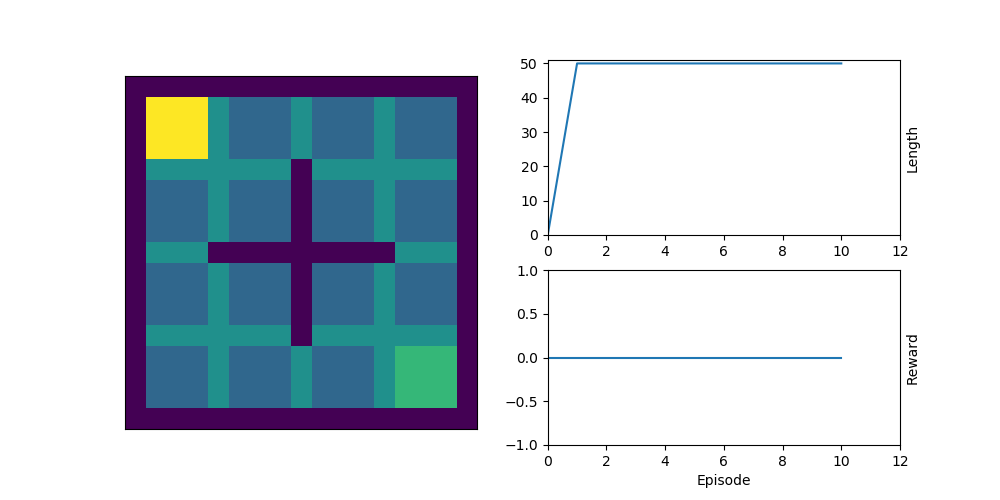

In [6]:
interactive = True
%matplotlib nbagg
env = SimpleRoomsEnv()
agent = DQLearningAgent(range(env.action_space.n), obs_size=16)
experiment = Experiment(env, agent)
experiment.run_qlearning(10, interactive)

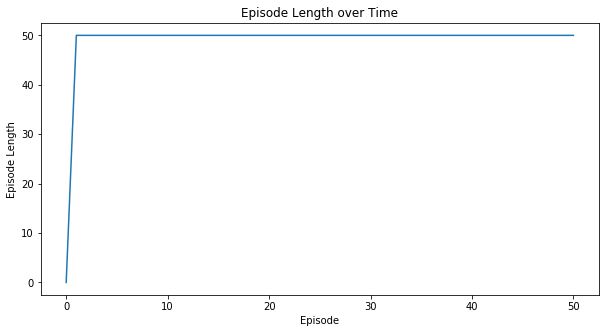

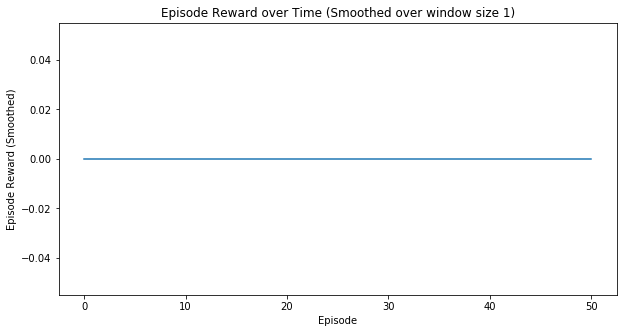

In [7]:
interactive = False
%matplotlib inline
env = SimpleRoomsEnv()
agent = DQLearningAgent(range(env.action_space.n), obs_size=16)
experiment = Experiment(env, agent)
experiment.run_qlearning(50, interactive)

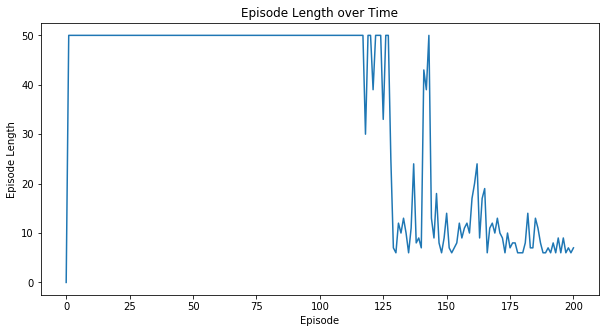

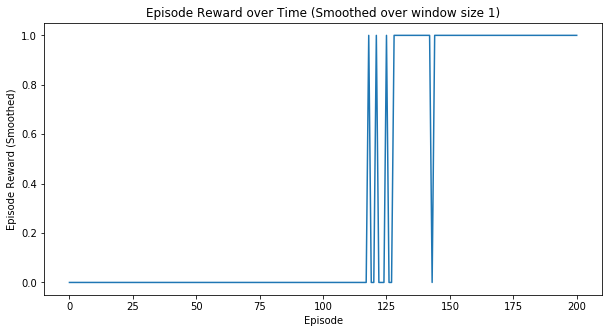

In [8]:
interactive = False
%matplotlib inline
env = SimpleRoomsEnv()
agent = DQLearningAgent(range(env.action_space.n), obs_size=16)
experiment = Experiment(env, agent)
experiment.run_qlearning(200, interactive)

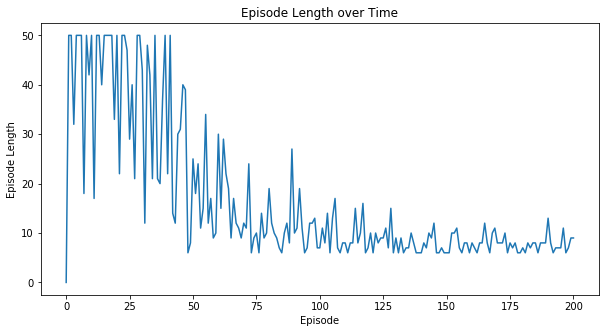

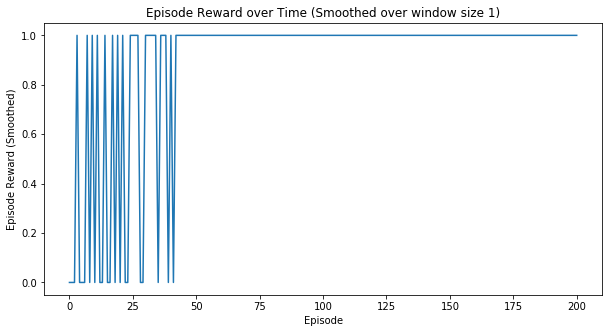

In [9]:
interactive = False
%matplotlib inline
env = SimpleRoomsEnv()
agent = DQLearningAgent(range(env.action_space.n), obs_size=16, epsilon=1)
experiment = Experiment(env, agent)
experiment.run_qlearning(200, interactive)